  Skipped (not file or hidden)
Found: 8.png
  Loaded successfully
Found: 9.png
  Loaded successfully
Found: 29.png
  Loaded successfully
Found: 21.png
  Loaded successfully
Found: 20.png
  Loaded successfully
Found: 22.png
  Loaded successfully
Found: 23.png
  Loaded successfully
Found: 25.png
  Loaded successfully
Found: 19.png
  Loaded successfully
Found: 4.png
  Loaded successfully
Found: 5.png
  Loaded successfully
Found: 7.png
  Loaded successfully
Found: 6.png
  Loaded successfully
Found: 2.png
  Loaded successfully
Found: 3.png
  Loaded successfully
Found: square 15.png
  Loaded successfully
Found: square 14.png
  Loaded successfully
Found: square 16.png
  Loaded successfully
Found: square 17.png
  Loaded successfully
Found: square 13.png
  Loaded successfully
  Skipped (not file or hidden)
Found: square 9.png
  Loaded successfully
Found: square 11.png
  Loaded successfully
Found: square 20.png
  Loaded successfully
Found: square 7.png
  Loaded successfully
Found: square 6.png
 

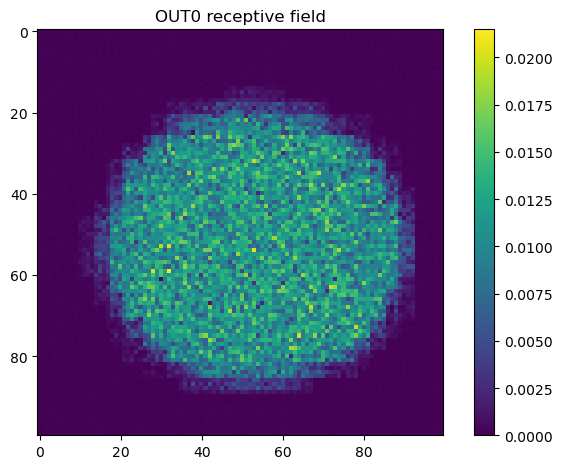

saved: STDP_homeostatic_high_epoh_never_test/rf_OUT1.png


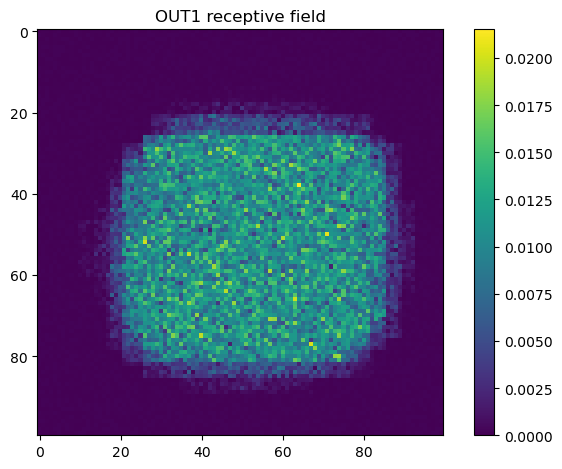

saved: STDP_homeostatic_high_epoh_never_test/rf_OUT2.png


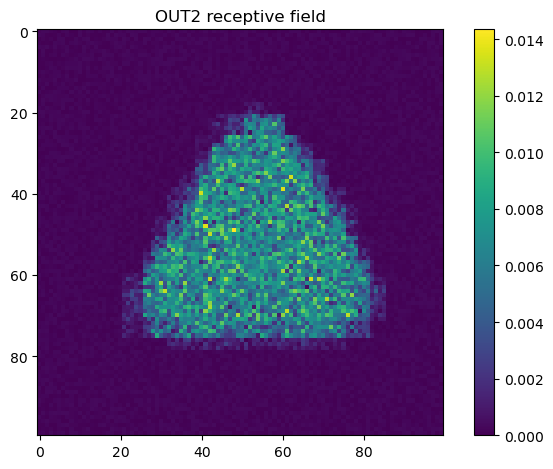

In [1]:
from brian2 import *
from pathlib import Path
import numpy as np
import imageio.v3 as iio
import matplotlib.pyplot as plt

(Path(directory := "STDP_homeostatic_high_epoh_never_test")).mkdir(parents=True, exist_ok=True)

images = list()
for folder in [
    Path("/Users/duaanaveed/Downloads/archive/training/shapes/train/circle"),
    Path("/Users/duaanaveed/Downloads/archive/training/shapes/train/square"),
    Path("/Users/duaanaveed/Downloads/archive/training/shapes/train/triangle"),
]:
    for file in folder.iterdir():
        if file.name.startswith('.'):
            print("  Skipped (not file or hidden)")
            continue
        if not file.is_file():
            print("  Skipped (not a file)")
            continue

        print("Found:", file.name)

        if file.suffix.lower() not in ['.png']:
            print("  Skipped (unsupported type)")
            continue

        try:
            img = iio.imread(file)                # read image into numpy array (grayscale expected)
            images.append(img)                    # save it for later
            print("  Loaded successfully")
        except Exception as e:
            print(f"  Skipped {file.name}: {e}")

print(f"\nTotal images loaded: {len(images)}")

# convert image to floats in [0,1] range
def normalize01(img):
    img = img.astype(float)   # make sure math works in float(not integers)
    # if pixel values = 0-255, scale down to 0-1
    if img.max() > 1.0:
        img = img / 255.0
    return img                      

# normalisation for every loaded image: mimics biology: real neurons don’t receive unlimitedly sized/strengthened signals,inputs(synaptic currents)naturally bounded
H, W  = imgs[0].shape   # takes image height+width from first image
Npix  = H * W           # total number of pixels per image = one neuron per pixel in input layer
# each input neuron=photoreceptors (light-sensing cells) covering some region of retina=one ganglion cell/lateral geniculate nucleus cells sends spikes about brightness=how bright that patch=how fast neuron fires
# retinotopic map(the receptive field images generated at the end)= retina + early visual cortex preserve spatial layout of image

labels = np.array([0]*15 + [1]*15 + [2]*15) # explicitly saying which neuron should spike= mimics biology:reward prediction errors

# image encoding - real neurons change continuously, network only calculates in small increments
defaultclock.dt = 1*ms     # virtual brain moves forward every 1 ms each time equations are updated after recalculating all variables
Ton, Tisi = 300*ms, 50*ms  # stimulus duration per image (Ton) + a short quiet period after (Tisi) (whole network level)
epochs    = 5              # how many passes over the whole dataset (do i explain why here?)
max_rate  = 10*Hz          # max firing rate for input neurons (upper bound for pixel→rate mapping) mimics biological firing limit for sensory neurons
                           # real neurons cant/dont fire infinitely fast (biological limit:refractory period(for input neurons)-brief recovery time after each spike)

def img_to_rates(img):
    return (1.0 - img.flatten()) * max_rate  #flips brightness so dark=high firing rate (close to 10 Hz); pixel dark (close to 1), rate might be close to max_rate, if pixel light (close to 0), rate might be near 0 Hz per ton
    # report you having to do this
    #return (img.flatten()) * max_rate

# poisson input layer 
IN = PoissonGroup(Npix, rates=0*Hz)  # generates spikes randomly at an average rate, starts off silent. if pixel is dark - more excitability; if light - less excitability
                                            # each neuron fires around an average rate, but precise spike times wander randomly around that average, exact intervals between spikes vary trial to trial
# mimics biology: neurons fire noisily w randomness, adding poisson=adding randomness+jitters
    #noise being: molecules drifting in n out of ion channels, random neurotransmitter release, differences in membrane potential,background signals from other neurons
# if i dont do poisson how does it train? does it think the first 15 will be circle based on order, will it memorise the rhythm instead?

# output layer w/ teacher bias
tau_m = 20*ms       # membrane time constant:controls how fast neuron voltage changes over time; mimics biology:in real neurons-depends on cell size+electrical properties
v_rest = 0*ms       # resting voltage of neuron (its idle state) mimics biology as resting neuron potential is -70mV
v_thr = 4*mV        # how high voltage climbs to trigger spike (neuron sensitivity/depolarisation) once internal voltage crosses this (spike), neuron sends an output spike to the next layer
v_reset = 0*mV      # after neuron fires spike, instantly reset voltage to this (repolarisation); mimics biology via how biological neurons “discharge” after firing|its zero bc the difference of change matters, not exact numbers
tau_e = 5*ms        # ge (excitation signal-makes neuron more likely to fire) how quickly excitation fades inside neuron after spike; quick excitement fading almost immediately
tau_i = 10*ms       # gi (inhibition signal-makes it less likely to fire) how quickly inhibition fades inside neuron after spike;stronger inhibition lasting longer
# no hyperpolarisation 

# “leaky integrate-and-fire” neuron equation w separate excitatory (ge)+inhibitory (gi) currents 
eqs_out = '''
dv/dt  = (-(v - v_rest) + ge - gi + Iteach) / tau_m : volt # describes how neuron voltage changes over time in model. voltage always trying to go back to rest, excitatory inputs push it up, inhibitory ones pull it down, teacher adds bias
dge/dt = -ge/tau_e : volt                                  # excitatory current decaying over time; rate of change of ge proportional to how big ge is, but in opposite direction (negative), mimics biology: temporary effect of excitatory neurotransmitters (ie: glutamate), wave of currrent:presynaptic neuron spikes=releases transmitter,receiving neuron excitatory channels open briefly(jump in ge)=they close=effect fades=decay
dgi/dt = -gi/tau_i : volt                                  # inhibitory current decaying over time; neuron stays suppressed for 10 ms after inhibitory spike, mimics biology: inhibitory neurotransmitters (like GABA) usually act a bit longer than excitatory,GABA opens channels that let negative ions (ie: Cl-) flow in=makes inside of neuron more negative=less likely to fire, after a few milliseconds, channels close, neuron returns to normal
Iteach : volt                                              # teaching current: small temporary electrical nudge added to right output neuron whenever image is shown to help it fire accordingly; makes it a little easier for neuron to reach threshold+fire during training; mimics biology: neuromodulators(ie:dopamine, acetylcholine, serotonin) that temporarily boost certain neurons when brain gets feedback/reward
s : integer                                                # keeps track of how many times neuron has spiked+stores whole numbers, shows which output neuron fires most-that becomes its prediction; mimics biology via firing rate (how many spikes per second a neuron emits to quantifying how strongly it’s responding to stimulus) 

'''

OUT = NeuronGroup(
    N=3, model=eqs_out,         # build 3 output neurons using model above
    threshold='v>v_thr',        # when v crosses threshold, neuron spikes
    reset='v=v_reset; s += 1',  # after spike, reset voltage+spike counter  
    refractory=6*ms,            # small no-spike period after each spike, mimics biology: a form of hyperpolarisation without becoming more negative-neuron is locked during recovery; immediately after, na+ channels inactivate(physically closed,won’t reopen right away) simultaneously, k+ channels open, pushing k+ ions out to bring voltage back down, until both channels reset, neuron cant produce another spike
    method='euler'              # “step-by-step” method; lets digital neuron change smoothly over simulated time=same way a real neuron’s voltage changes smoothly in real time; brian2 has different solvers for advancing time
)

OUT.v = v_rest                     # resets every neuron’s voltage to resting level, so none start w charge
if hasattr(OUT, 'ge'): OUT.ge = 0  # sets all excitatory currents to zero
if hasattr(OUT, 'gi'): OUT.gi = 0  # sets all inhibitory currents to zero
# hasattr basically checks if the neuron group has the variable, and if it does to make sure its at zero
# mimics biology: real neurons do similarly between stimuli=reset membrane voltage back toward resting potential,excitatory+inhibitory currents decay,by the time next signal comes, neuron is ready to respond cleanly

# BDNF profiles (my own variables)
BDNF_PROFILES = {      #have it show output of its prediction process, also could tell it that the inverse and the regular image means the same thing.
    "low": {
        "eta_scale": 0.5,     # overall learning speed/plasticity; mimics biology: higher BDNF signaling often raises plasticity “gains”(synapses change more from same activity), lower BDNF dampens
        "ltp_scale": 0.8,     # connection between two neurons gets stronger: easier to activate in future
        "ltd_scale": 1.1,     # connection between two neurons gets weaker: harder to activate in future; is often reduced when BDNF is high
        "norm_every": 1,      # normalise every x epochs; synaptic scaling (gina turrigiano):neurons globally scale all synapses up/down to maintain target firing rate, if cell fires too much=proportionally downscales all excitatory weights, if too silent = upscales
    },
    "medium": {
        "eta_scale": 1.0,
        "ltp_scale": 1.0,
        "ltd_scale": 1.0,
        "norm_every": 2,
    },
    "high": {
        "eta_scale": 1.5,
        "ltp_scale": 1.2,     
        "ltd_scale": 0.9,     
        "norm_every": 3,
    },
    "high_homeostatic": {
        "eta_scale": 1.3,      # still elevated plasticity, but dampened slightly
        "ltp_scale": 1.1,      # balanced potentiation
        "ltd_scale": 0.95,     # nearly symmetric depression
        "norm_every": 3, 
    },
}

BDNF_LEVEL = "high_homeostatic" 

# mimic biology: ltd/ltp dependent on low/high ca+ respectively, travelling into postsynaptic neuron through NMDA receptors.

# base STDP: default learning behaviour before BDNF profile variables
eta_base   = 0.02        # how fast learning happens overall for both ltd/ltp; mimics biology:how chemically “plastic” neuron is,how readily its synapses strengthen/weaken during activity,neuromodulators/BDNF raise/lower this
Apre_base  = 0.015       # how strong strengthening events are, makes ltp opportunity larger bc apre is what postsynaptic event uses to increase w; mimics biology: how strongly presynaptic event “primes” synapse for strengthening/ltp if postsynaptic cell fires right after(ie: more glutamate/NMDA-driven Ca²⁺ signal ready to trigger ltp)
Apost_base = -0.016      # how strong weakening events are; biases base model slightly toward ltd but is countered by BDNF scaling+teacher bias; mimics biology: ie. ca2+ pattern favoring phosphatases=receptor removal=ltd if pre activity follows too late

# apply BDNF profile
_bd = BDNF_PROFILES[BDNF_LEVEL]
eta   = eta_base  * _bd["eta_scale"]
Apre  = Apre_base * _bd["ltp_scale"]      # memory of when the input neuron last fired
Apost = Apost_base* _bd["ltd_scale"]      # memory of when the output neuron last fired

norm_every = _bd["norm_every"]
print(f"[BDNF={BDNF_LEVEL}] eta={eta:.4f}, Apre={Apre:.4f}, Apost={Apost:.4f}, norm_every={norm_every}")

taupre  = 10*ms  # how long input neuron’s trace lasts after spike; apre still positive when post spike happens=LTP (weight goes up)
taupost = 10*ms  # how long output neuron’s trace lasts after spike; apost (negative) still present when pre spike happens=LTD (weight goes down).
# mimics biology: chemical signals (ie: ca2+) rise briefly after spikes then decay over a few ms-that decides whether connection strengthens/weakens
wmax    = 0.05   # ceiling for each synapse’s strength, weights can’t exceed this value, prevents synapses from growing w/out bound+dominating everything; mimics biology:real synapses have physical/biochemical limits (ie: limited receptors can be packed in, limited vesicles can release etc)
wscale  = 5*mV   # converts dimensionless weight w into actual voltage kick on postsynaptic neuron when an input spike occurs, how strongly each presynaptic spike affects postsynaptic neuron: by releasing neurotransmitters at a synapse=bind to receptors=cause a change in postsynaptic neuron membrane potential

S = Synapses(IN, OUT,                                  # represents the synapase between the pre-synaptic & post-synaptic neuron, the strength of the connection between the two
    model='''
        w : 1                                          # strength/scaling factor' weight meaning the strength of that connection, 30000 separate weights values; mimics biology: synaptic efficacy - how much presynaptic neuron’s spike changes voltage of postsynaptic neuron, bigger w = more neurotransmitter released/more receptors = stronger effect
        dapre/dt  = -apre/taupre  : 1 (event-driven)   # pre-trace decays over time, event-driven means it only updates when there's a spike; mimics biology: chemical trace left behind in synapse after presynaptic neuron fires, few milliseconds of elevated neurotransmitter/intracellular signaling (ie: short-lived glutamate/presynaptic ca2+)
        dapost/dt = -apost/taupost : 1 (event-driven)  # post-trace decays over time; mimics biology: temporary rise in ca2+/activation of signaling enzymes right after postsynaptic neuron fires
    ''', #
    on_pre=''' 
        ge_post += w * wscale                          # add an amount of excitatory conductance to postsynaptic neuron equal to this synapse’s strength (w) times scaling factor (wscale); mimics biology: neurotransmitter release: spike opens channels on postsynaptic neuron, letting positive ions flow in: small excitatory voltage bump            
        apre += Apre                                   # when presynaptic neuron spikes, pre-trace gets little bump, apre=size of that bump; mimic biology: presynaptic terminal now “remembers” it just fired (ie: ca2+ entering termina/vesicle release probability increases)
        w = clip(w + eta*apost, 0, wmax)               # adjust synaptic weight using postsynaptic trace (apost)xlearning rate+w that’s still lingering from recent postsynaptic spikes, using apost bc if postsynaptic neuron fired shortly before, apost is negative so this decreases w = ltd;mimics biology:output fired before i did=my signal didn’t cause it=make this synapse a little weaker,corresponds to ltd driven by low ca2+/phosphatase activity
    ''',
    on_post='''
        apost += Apost                                 # each post-spike adds negative bump to post-trace to ensure this trace will trigger ltd later if pre-spike follows; mimics biology: postsynaptic neuron releases internal signals (ie: ca2+) that briefly mark synapse as recently active
        w = clip(w + eta*apre, 0, wmax)                # update weight using pre-trace (apre) that’s lingering from recent presynaptic activity, if pre-spike happened just before, apre is positive=ltp. mimics biology:input fired right before I did, it probably helped me fire, strengthen synapse=ltp via strong, rapid ca2+ influx
    ''',
    method='euler'                                     # “step-by-step” method; lets digital neuron change smoothly over simulated time=same way a real neuron’s voltage changes smoothly in real time; brian2 has different solvers for advancing time
)
# hebbian learning: synpases the fire together, wire together; if fired out of sync, they lose their link
# if during training connection repeatedly fires right before the correct output neuron, STDP will increase w (lap), if it fires out of sync, STDP will decrease w (ltd), over time, only input neurons that consistently help cause correct output spike keep high weights - forming the receptive field - not averaging
# while apre has residue from pre spike, the post spike happens, then when the network reaches on_post and sees apre > 0, it increases the weight=ltp; 
# without clipping, weights could grow infinitely if ltp keeps pushing them upward or become negative if LTD keeps pulling them downward; neurons would start firing nonstop, or connections could become inhibitory when they’re meant to be excitatory; mimics biology: real synapses also have limits (ie: can only insert so many receptor proteins, no “negative” synapses (either connects weakly or not at all), structural/molecular constraints set size of synapse)


# connectivity
S.connect(True)            # fully connect every input pixel to all three output neurons          
S.w = '0.002*rand()'       # start weights small + random                 
S.apre  = 0                # start traces at zero bc no actvity yet
S.apost = 0
    
# lateral inhibition; mimics the same concept in biology
ginh = 1*mV                           # size of inhibitory kick to other two neurons when one output neuron spikes
Sinhib = Synapses(OUT, OUT, on_pre='gi_post += ginh') # making new synapses that connect the output layer to itself, each output neuron can send inhibition to every other output neuron
Sinhib.connect(condition='i != j')    # build inhibitory synapses between all different pairs of output neurons, except where i == j: with itself
Sinhib.delay = 1*ms                   # transmission delay for inhibitory effect so it doesnt block the spike that triggered it, only subsequent ones

# monitors
spike_inp = SpikeMonitor(IN)                                    # count overall input spikes
spike_out = SpikeMonitor(OUT)                                   # count overall output spikes
rate_inp  = PopulationRateMonitor(IN)                           # track average firing rate of all input neurons over time
state_inp = StateMonitor(IN, 'rates', record=True)              # tracking stimulus intensity being fed into each sensory neuron
state_out = StateMonitor(OUT, ['v', 'ge', 'gi'], record=True)   # recording intracellular voltage trace + excitatory/inhibitory synaptic currents from real neuron w microelectrodes

# training loop
net = Network(collect())   # gather all variable into a single brian2 network object
teacher_amp = 6*mV         # amount of extra voltage/bias given to correct output neuron during stimulus/Ton

# running accuracy counters
correct = 0
seen = 0

for ep in range(epochs):
    order = np.random.permutation(len(imgs))  # shuffle image order each epoch to avoid learning by fixed order
    for k in order:
        # 1. set poisson rates for image to convert image into input firing rates; each pixel acts as sensory neuron firing at a rate proportional to how dark the spot is=spike-encoded version of visual scene: same way retina/lateral geniculate nucleus sends spike trains to primary visual cortex
        label_scalar = int(labels[k])
        IN.rates = img_to_rates(imgs[k])
        img_k = imgs[k]
        rates = IN.rates
        print("img stats:", img_k.min(), img_k.max(), "nonzero px:", np.count_nonzero(img_k))
        print("rate stats:", float((rates/Hz).min()), float((rates/Hz).max()))
        
        # 2. turn on teacher signal only for the correct output neuron; supervised learning in brain
        OUT.Iteach = 0*volt                        # clear any leftover bias
        OUT.Iteach[label_scalar] = teacher_amp     # apply voltage boost only to correct output neuron
        OUT.s = 0                                  # reset spike counters before trial
        # mimics biology: would be done by dopamine/other neuromodulators
        
        print('OUT has ge?', 'ge' in OUT.variables)
        if 'ge' in OUT.variables:
            print('ge unit:', OUT.variables['ge'].unit)
            print('ge mean (pre-run):', float(np.mean(OUT.ge)))

        print('w min/mean/max:', float(np.min(S.w)), float(np.mean(S.w)), float(np.max(S.w))) # snapshot of synaptic strength distribution in cortex before learning
        print('v start (mV):', list(np.round(OUT.v[:] / mV, 2)))
        print('vt (mV):', float(v_thr/mV))

        prev_spikes = spike_inp.num_spikes    # record how many spikes input layer has already emitted
        
        # 3. present image
        net.run(Ton)
        print("Δinput spikes:", spike_inp.num_spikes - prev_spikes)  # see how many new spikes occurred
        # represents when visual system actively perceiving stimulus (ie: eyes fixate on object for ~300 ms), during that retinal ganglion cells send spike trains, visual cortical neurons integrate those inputs, one output neuron fires first (“winner”), STDP strengthens causal pathways + weakens irrelevant ones

        # read per-neuron spike counts & pick answer
        counts = OUT.s[:]                 # ie: array([12, 1, 0])
        pred   = int(np.argmax(counts))   # index of neuron w most spikes, neuron that spikes most strongly “represents” object, similar to how real cortical neurons in primary visual cortex or IT (inferotemporal cortex) respond selectively to particular shapes/objects
        is_ok  = (pred == int(labels[k]))
        correct += int(is_ok)
        seen += 1
        print(f"img {k:02d} label={labels[k]} counts={counts} → pred={pred} {'✓' if is_ok else '✗'}")
        
        # 4. inter-stimulus: silence input & teacher; pause between stimuli, membrane potentials return to resting levels + ca2+ traces decay, so each new stimulus is fresh
        IN.rates   = 0*Hz
        OUT.Iteach[:] = 0*mV
        OUT.v  = v_rest
        OUT.ge = 0*mV
        OUT.gi = 0*mV
        S.apre = 0
        S.apost = 0
        net.run(Tisi)

    # epoch summary
    print(f"[epoch {ep+1}] running accuracy: {correct}/{seen} = {100*correct/seen:.1f}%")

    # normalisation; keeps total synaptic strength balanced so no neuron monopolises all weights
    if (ep + 1) % norm_every == 0:       
        i = np.array(S.i[:]); j = np.array(S.j[:])
        for out_idx in np.unique(j):                  
            idx = np.where(j == out_idx)[0]           # find all synapses that go into this output neuron
            total = float(np.sum(S.w[idx]))           # sum of its incoming weights
            if total > 0:                             # if nonzero, rescale weights so overall size is controlled
                S.w[idx] *= (1.0 / total)**0.5   
        print(f"[BDNF={BDNF_LEVEL}] soft-normalised incoming weights")

n_post = len(np.unique(S.j[:]))   
n_pre  = len(np.unique(S.i[:]))   

print("n_pre =", n_pre, "n_post =", n_post, "total weights =", len(S.w[:]))

# build (inputs x outputs) weight matrix for plotting
Wmat = np.zeros((n_pre, n_post))
for i, j, w in zip(S.i[:], S.j[:], S.w[:]):
    Wmat[i, j] = w

# for each output neuron, reshape weights back to image shape and save heatmap/receptive field
for k in range(n_post):
    fig, ax = plt.subplots()
    im = ax.imshow(Wmat[:, k].reshape(H, W))
    ax.set_title(f'OUT{k} receptive field')
    fig.colorbar(im, ax=ax)
    fig.tight_layout()

    out_png = Path(directory) / f"rf_OUT{k}.png"
    fig.savefig(out_png, dpi=150, bbox_inches="tight")
    print("saved:", out_png)

    plt.show()


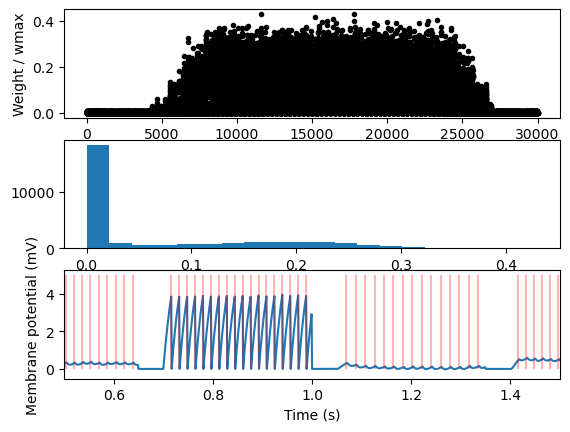

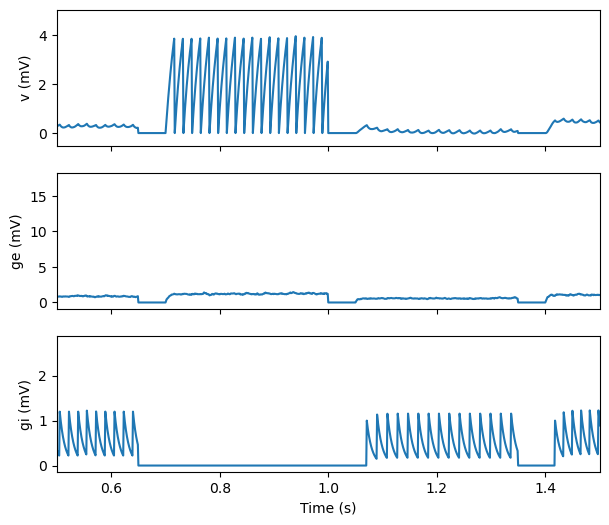

In [24]:
subplot(311)
plot(S.w / wmax, '.k')
ylabel('Weight / wmax')
xlabel('Synapse index')
subplot(312)
hist(S.w / wmax, 20)
xlabel('Weight / wmax')
subplot(313)
plot(state_out.t/second, state_out.v[0]/mV)
vlines(spike_out.t/second, ymin=0, ymax=5, color='r', alpha=0.3)
xlim(0.5, 1.5)
xlabel('Time (s)')
ylabel('Membrane potential (mV)')
fig, ax = plt.subplots(3, 1, sharex=True, figsize=(7,6))

ax[0].plot(state_out.t/second, state_out.v[0]/mV)
ax[0].set_ylabel('v (mV)')
plt.xlim(0.5, 1.5)

ax[1].plot(state_out.t/second, state_out.ge[0]/mV)   
ax[1].set_ylabel('ge (mV)')
plt.xlim(0.5, 1.5)

ax[2].plot(state_out.t/second, state_out.gi[0]/mV)   
ax[2].set_ylabel('gi (mV)')
ax[2].set_xlabel('Time (s)')
plt.xlim(0.5, 1.5)

#tight_layout()
show()